In [75]:
import pandas as pd
import numpy as np

In [106]:
df = pd.read_csv('/Users/sarthakkumar/Documents/Sarthak-Github/Graph-ML/data_folder/stock_predictions_V4.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df['actual'] = df['actual']*100
df['predicted'] = df['predicted']*100
df.head()

,stock_id,time_step,actual,predicted
0,0,0,2.515441,0.075678
1,0,1,-0.341549,-0.353799
2,0,2,2.164505,-0.454491
3,0,3,-1.200566,0.273279
4,0,4,-0.777334,0.041021


In [120]:
df = df[df['time_step']<=3]

In [121]:
df['actual_direction'] = np.where(df['actual']>=0,"UP","DOWN")
df['predicted_direction'] = np.where(df['predicted']>=0,"UP","DOWN")
df.head()

,stock_id,time_step,actual,predicted,actual_direction,predicted_direction
0,0,0,2.515441,0.075678,UP,UP
1,0,1,-0.341549,-0.353799,DOWN,DOWN
2,0,2,2.164505,-0.454491,UP,DOWN
3,0,3,-1.200566,0.273279,DOWN,UP
7,1,0,2.529825,-0.276792,UP,DOWN


In [122]:
pd.crosstab(df['predicted_direction'],df['actual_direction'])

actual_direction,DOWN,UP
predicted_direction,,
DOWN,606,669
UP,206,487


Accuracy: 0.5553861788617886
Precision: 0.7027417027417028
Recall: 0.421280276816609
F1 Score: 0.5267712276906437

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.48      0.75      0.58       812
          UP       0.70      0.42      0.53      1156

    accuracy                           0.56      1968
   macro avg       0.59      0.58      0.55      1968
weighted avg       0.61      0.56      0.55      1968



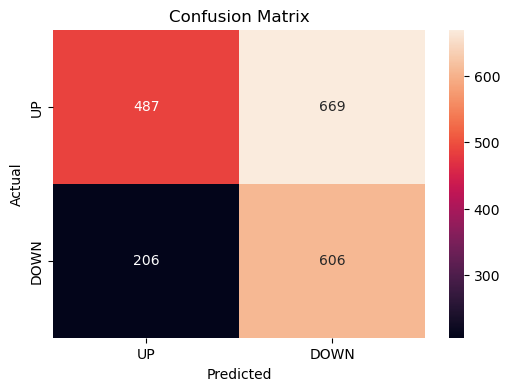

array([[487, 669],
       [206, 606]])

In [123]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_direction(df):
    y_true = df["actual_direction"]
    y_pred = df["predicted_direction"]

    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label="UP")
    rec = recall_score(y_true, y_pred, pos_label="UP")
    f1 = f1_score(y_true, y_pred, pos_label="UP")

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["UP", "DOWN"])

    # Heatmap for confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["UP", "DOWN"], yticklabels=["UP", "DOWN"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return cm
cm = evaluate_direction(df)
cm

In [116]:
def regression_per_stock(df):
    results = []

    for stock_id, g in df.groupby("stock_id"):
        actual = g["actual"].values
        pred = g["predicted"].values

        # Basic errors
        abs_error = np.abs(actual - pred)
        pct_error = abs_error / (np.abs(actual) + 1e-9)  # protect div by zero

        mae = abs_error.mean()
        mse = np.mean((actual - pred) ** 2)
        rmse = np.sqrt(mse)
        mape = pct_error.mean() * 100

        # Performance category
        if mape <= 10:
            grade = "GOOD"
        elif mape <= 20:
            grade = "MEDIUM"
        else:
            grade = "BAD"

        results.append({
            "stock_id": stock_id,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "MAPE_%": mape,
            "Performance": grade
        })

    results_df = pd.DataFrame(results)

    # Sort: best first (lowest MAPE)
    results_df = results_df.sort_values("MAPE_%")

    return results_df
stats = regression_per_stock(df)
stats

,stock_id,MAE,MSE,RMSE,MAPE_%,Performance
381,381,0.324362,0.212096,0.460539,4.511195e+01,BAD
255,255,0.825895,1.485344,1.218747,5.731116e+01,BAD
5,5,1.055768,1.769098,1.330074,6.374562e+01,BAD
89,89,0.436289,0.343357,0.585966,6.400804e+01,BAD
251,251,0.551708,0.594404,0.770976,6.495440e+01,BAD
...,...,...,...,...,...,...
407,407,0.792622,0.892743,0.944851,6.282652e+09,BAD
479,479,2.189766,7.363399,2.713558,6.304570e+09,BAD
439,439,0.678984,0.648990,0.805599,6.856569e+09,BAD
336,336,0.825388,0.915698,0.956921,8.022386e+09,BAD


In [117]:
stats.Performance.value_counts()


Performance
BAD    492
Name: count, dtype: int64

In [ ]:
## Analysis on good stock

stats_good = stats[stats['Performance']=='GOOD']
df_good = df[df['stock_id'].isin(stats_good['stock_id'])]
cm_good = evaluate_direction(df_good)
cm_good

/opt/anaconda3/envs/gnn_test/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/envs/gnn_test/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/gnn_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/gnn_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/gnn_test/lib/python3.8/site-p

Accuracy: nan
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Classification Report:


ValueError: max() arg is an empty sequence

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
              precision    recall  f1-score   support

        DOWN       1.00      1.00      1.00       504
          UP       1.00      1.00      1.00        49

    accuracy                           1.00       553
   macro avg       1.00      1.00      1.00       553
weighted avg       1.00      1.00      1.00       553



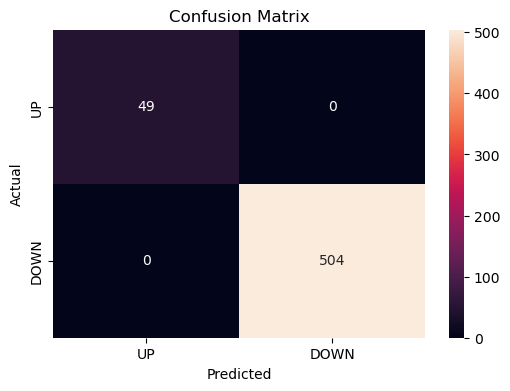

array([[ 49,   0],
       [  0, 504]])

In [83]:
## Analysis on medium stock
stats_medium = stats[stats['Performance']=='MEDIUM']
df_medium = df[df['stock_id'].isin(stats_medium['stock_id'])]
cm_medium = evaluate_direction(df_medium)
cm_medium

Accuracy: 0.5020325203252033
Precision: 0.6578341013824884
Recall: 0.32740825688073394
F1 Score: 0.43721286370597245

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.44      0.75      0.55      1208
          UP       0.66      0.33      0.44      1744

    accuracy                           0.50      2952
   macro avg       0.55      0.54      0.50      2952
weighted avg       0.57      0.50      0.48      2952



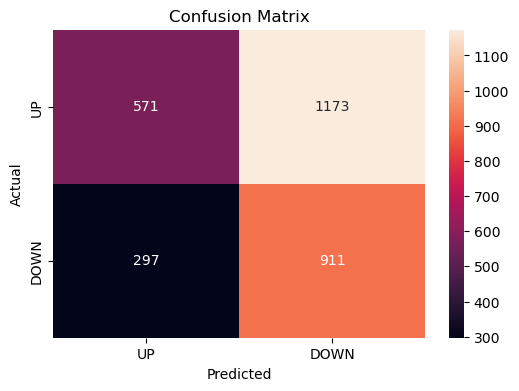

array([[ 571, 1173],
       [ 297,  911]])

In [119]:
## Analysis on bad stock
stats_bad = stats[stats['Performance']=='BAD']
df_bad = df[df['stock_id'].isin(stats_bad['stock_id'])]
cm_bad = evaluate_direction(df_bad)
cm_bad

In [85]:
#### Lets analyze the stocks now

df = pd.read_csv('/Users/sarthakkumar/Documents/Sarthak-Github/Graph-ML/data_folder/stock_data_collated.csv')


train_dfs = []
val_dfs = []

for ticker in df['Ticker'].unique():
    df_ticker = df[df['Ticker'] == ticker].sort_values('Date')
    n = len(df_ticker)
    split_idx = int(np.floor(0.85 * n))
    train_dfs.append(df_ticker.iloc[:split_idx])
    val_dfs.append(df_ticker.iloc[split_idx:])

stocks = pd.concat(train_dfs).reset_index(drop=True)
# ignore = pd.concat(val_dfs).reset_index(drop=True)
stocks.head()

,Date,Ticker,Open,High,Low,Close,Volume,ticker,sector,VIX_Open,VIX_High,VIX_Low,VIX_Close,avg_sentiment
0,2021-11-15,MMM,131.017793,131.693911,130.170867,130.462662,1750226,MMM,Conglomerates,17.030001,17.459999,16.490000,16.490000,NaN
1,2021-11-16,MMM,130.462666,131.096091,130.028533,130.505371,2362100,MMM,Conglomerates,16.860001,17.080000,16.030001,16.370001,NaN
2,2021-11-17,MMM,130.505346,130.861199,129.266980,130.483994,2692316,MMM,Conglomerates,16.360001,17.190001,16.280001,17.110001,NaN
3,2021-11-18,MMM,130.663369,130.971889,128.209533,128.266937,3029229,MMM,Conglomerates,16.809999,18.150000,16.379999,17.590000,NaN
4,2021-11-19,MMM,128.747642,129.730606,127.800542,128.596970,2969190,MMM,Conglomerates,17.360001,19.010000,17.230000,17.910000,NaN


In [86]:
stocks['stock_id'] = stocks['Ticker'].astype('category').cat.codes
stocks.head(20)

,Date,Ticker,Open,High,Low,Close,Volume,ticker,sector,VIX_Open,VIX_High,VIX_Low,VIX_Close,avg_sentiment,stock_id
0,2021-11-15,MMM,131.017793,131.693911,130.170867,130.462662,1750226,MMM,Conglomerates,17.030001,17.459999,16.490000,16.490000,NaN,302
1,2021-11-16,MMM,130.462666,131.096091,130.028533,130.505371,2362100,MMM,Conglomerates,16.860001,17.080000,16.030001,16.370001,NaN,302
2,2021-11-17,MMM,130.505346,130.861199,129.266980,130.483994,2692316,MMM,Conglomerates,16.360001,17.190001,16.280001,17.110001,NaN,302
3,2021-11-18,MMM,130.663369,130.971889,128.209533,128.266937,3029229,MMM,Conglomerates,16.809999,18.150000,16.379999,17.590000,NaN,302
4,2021-11-19,MMM,128.747642,129.730606,127.800542,128.596970,2969190,MMM,Conglomerates,17.360001,19.010000,17.230000,17.910000,NaN,302
5,2021-11-22,MMM,128.611348,130.785353,128.274113,128.905518,2836792,MMM,Conglomerates,18.200001,19.590000,17.350000,19.170000,NaN,302
6,2021-11-23,MMM,129.587125,130.096546,128.180833,128.762009,2325263,MMM,Conglomerates,20.240000,20.910000,19.030001,19.379999,NaN,302
7,2021-11-24,MMM,128.410441,128.790716,127.384410,127.448990,1780246,MMM,Conglomerates,19.170000,20.959999,18.520000,18.580000,NaN,302
8,2021-11-26,MMM,125.217599,126.875008,124.413996,125.935097,2287111,MMM,Conglomerates,26.620001,28.990000,23.879999,28.620001,NaN,302
9,2021-11-29,MMM,126.616687,126.874979,125.547617,126.444489,2780102,MMM,Conglomerates,25.309999,25.690001,21.709999,22.959999,NaN,302


In [87]:
stocks.drop_duplicates(subset=['Ticker'],inplace=True)
stocks.head()

,Date,Ticker,Open,High,Low,Close,Volume,ticker,sector,VIX_Open,VIX_High,VIX_Low,VIX_Close,avg_sentiment,stock_id
0,2021-11-15,MMM,131.017793,131.693911,130.170867,130.462662,1750226,MMM,Conglomerates,17.030001,17.459999,16.49,16.49,NaN,302
854,2021-11-15,AOS,76.209340,76.209340,75.335718,75.986290,782900,AOS,Specialty Industrial Machinery,17.030001,17.459999,16.49,16.49,NaN,34
1708,2021-11-15,ABT,119.468016,120.794709,118.994847,120.089615,4565800,ABT,Medical Devices,17.030001,17.459999,16.49,16.49,NaN,4
2562,2021-11-15,ABBV,100.851710,101.584712,100.222199,100.756851,3941000,ABBV,Drug Manufacturers - General,17.030001,17.459999,16.49,16.49,NaN,2
3416,2021-11-15,ACN,350.317058,350.646867,346.821151,347.188660,1957400,ACN,Information Technology Services,17.030001,17.459999,16.49,16.49,NaN,6


In [88]:
df_good = df_good.merge(stocks[['Ticker','stock_id']],on='stock_id',how='left')
df_good

,stock_id,time_step,actual,predicted,actual_direction,predicted_direction,Ticker
0,5,0,-22.859511,-22.477889,DOWN,DOWN,ACGL
1,5,1,-22.623755,-22.802818,DOWN,DOWN,ACGL
2,5,2,-22.634117,-22.771558,DOWN,DOWN,ACGL
3,5,3,-23.079723,-22.765999,DOWN,DOWN,ACGL
4,5,4,-22.356910,-23.110723,DOWN,DOWN,ACGL
...,...,...,...,...,...,...,...
618,482,2,-40.125427,-38.813335,DOWN,DOWN,WY
619,482,3,-40.110546,-39.134496,DOWN,DOWN,WY
620,482,4,-40.159371,-38.813591,DOWN,DOWN,WY
621,482,5,-40.190211,-38.946819,DOWN,DOWN,WY


In [89]:
df_good.Ticker.nunique()

89

In [92]:
## Meta data
md = pd.read_csv('/Users/sarthakkumar/Documents/Sarthak-Github/Graph-ML/data_folder/stock_data_collated.csv')
md.head()

,Date,Ticker,Open,High,Low,Close,Volume,ticker,sector,VIX_Open,VIX_High,VIX_Low,VIX_Close,avg_sentiment
0,2021-11-15,MMM,131.017793,131.693911,130.170867,130.462662,1750226,MMM,Conglomerates,17.030001,17.459999,16.490000,16.490000,NaN
1,2021-11-16,MMM,130.462666,131.096091,130.028533,130.505371,2362100,MMM,Conglomerates,16.860001,17.080000,16.030001,16.370001,NaN
2,2021-11-17,MMM,130.505346,130.861199,129.266980,130.483994,2692316,MMM,Conglomerates,16.360001,17.190001,16.280001,17.110001,NaN
3,2021-11-18,MMM,130.663369,130.971889,128.209533,128.266937,3029229,MMM,Conglomerates,16.809999,18.150000,16.379999,17.590000,NaN
4,2021-11-19,MMM,128.747642,129.730606,127.800542,128.596970,2969190,MMM,Conglomerates,17.360001,19.010000,17.230000,17.910000,NaN


In [93]:
df_good.head()

,stock_id,time_step,actual,predicted,actual_direction,predicted_direction,Ticker
0,5,0,-22.859511,-22.477889,DOWN,DOWN,ACGL
1,5,1,-22.623755,-22.802818,DOWN,DOWN,ACGL
2,5,2,-22.634117,-22.771558,DOWN,DOWN,ACGL
3,5,3,-23.079723,-22.765999,DOWN,DOWN,ACGL
4,5,4,-22.356910,-23.110723,DOWN,DOWN,ACGL


In [100]:
# row-wise absolute percentage error
df_good['ape'] = np.abs(df_good['actual'] - df_good['predicted']) / (np.abs(df_good['actual']) + 1e-9)

# MAPE per ticker
ticker_mape = df_good.groupby('Ticker')['ape'].mean() * 100

df_good['mape'] = df_good.groupby('Ticker')['ape'].transform('mean') * 100
df_good

,stock_id,time_step,actual,predicted,actual_direction,predicted_direction,Ticker,mape,ape
0,5,0,-22.859511,-22.477889,DOWN,DOWN,ACGL,1.960255,0.016694
1,5,1,-22.623755,-22.802818,DOWN,DOWN,ACGL,1.960255,0.007915
2,5,2,-22.634117,-22.771558,DOWN,DOWN,ACGL,1.960255,0.006072
3,5,3,-23.079723,-22.765999,DOWN,DOWN,ACGL,1.960255,0.013593
4,5,4,-22.356910,-23.110723,DOWN,DOWN,ACGL,1.960255,0.033717
...,...,...,...,...,...,...,...,...,...
618,482,2,-40.125427,-38.813335,DOWN,DOWN,WY,3.140669,0.032700
619,482,3,-40.110546,-39.134496,DOWN,DOWN,WY,3.140669,0.024334
620,482,4,-40.159371,-38.813591,DOWN,DOWN,WY,3.140669,0.033511
621,482,5,-40.190211,-38.946819,DOWN,DOWN,WY,3.140669,0.030938


In [104]:
df_good['mape'].describe(percentiles=np.arange(0, 1, 0.1))

count    623.000000
mean       2.422843
std        1.232621
min        0.432488
0%         0.432488
10%        0.839442
20%        1.277953
30%        1.523454
40%        1.763633
50%        2.069144
60%        2.806595
70%        3.167452
80%        3.837807
90%        4.238312
max        4.986534
Name: mape, dtype: float64